In [2]:
from model import MMSegModel,get_clip,KoGPT
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch as AP
import clip
import numpy as np
import torch
from glob import glob
import os

2021-12-18 09:41:05.861579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/api-server/lib/python3.7/site-packages/cv2/../../lib64:
2021-12-18 09:41:05.861618: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## model load

In [3]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seg_model = MMSegModel(
    cfg = './assets/segmentation/swinT_segformer.py',
    checkpoint = './assets/segmentation/weights.pth',
    device = 'cuda')

clip_model, _ = get_clip(device)

preprocess = A.Compose([
    A.SmallestMaxSize(clip_model.visual.input_resolution),
    A.CenterCrop(clip_model.visual.input_resolution,clip_model.visual.input_resolution),
    A.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    AP.ToTensorV2()
])

kogpt_model = KoGPT(pretrained='larcane/kogpt2-cat-diary',device=device)




load checkpoint from local path: ./assets/segmentation/weights.pth


## Define label
1. define actions / emotions labels
2. define dict that map eng labels to kor labels
    - **clip model is not fine-tuned model**
3. get tokenized labels

In [4]:

actions = [
    'a picture of cat lying down',
    'a picture of cat lying on side',
    'a picture of grooming cat',
    'a picture of playing cat',
    'a picture of cat punching',
    'a picture of cat eating',
    # 'hugged cat',
    # 'box cat',
    # 'liquid cat',
    # 'upside down cat',
]

emotions = [
    'a picture of sleeping cat',
    'a picture of sleepy cat', # 누워서 자고 있지 않은 것 (하품, 앉아서 자는 고양이 등)
    'a picture of happy cat',
    'a picture of comfortable cat',
    'a picture of curious cat',
    'a picture of perplexed cat',
    'a picture of scared cat',
    'a picture of sad cat',
    'a picture of cloudy cat',
    'a picture of angry cat',
]

labels_eng2kor = {
    'a picture of cat lying down':"엎드려있는 고양이",
    'a picture of cat lying on side':"옆으로 누워있는 고양이",
    'a picture of grooming cat' :"그루밍하는 고양이",
    'a picture of playing cat' :"놀고있는 고양이",
    'a picture of cat punching' :"펀치를 하는 고양이",
    'a picture of cat eating' :"밥을 먹는 고양이",
    'a picture of sleeping cat' :"자고 있는 고양이",
    'a picture of sleepy cat':"졸린 고양이", 
    'a picture of happy cat' :"행복한 고양이",
    'a picture of comfortable cat' :"편안한 고양이",
    'a picture of curious cat':"궁금해하는 고양이",
    'a picture of perplexed cat':"당황한 고양이",
    'a picture of scared cat':"무서워하는 고양이",
    'a picture of sad cat':"슬픈 고양이",
    'a picture of cloudy cat':"언짢은 고양이",
    'a picture of angry cat':"화난 고양이",
}


action_tokens = clip.tokenize(actions).to(device)
emotion_tokens = clip.tokenize(emotions).to(device)

### Image Load

In [ ]:
image_path = './assets/cat.jpg'
image = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)

In [5]:

_,masked_img = seg_model(image)
masked_img = masked_img.astype(np.uint8)

processed_img = preprocess(image=image)['image'].unsqueeze(0).to(device)
processed_masked_img = preprocess(image=masked_img)['image'].unsqueeze(0).to(device)

# 1. masked_img와 emotion token/ action token
# 2. emotion token이 큰 순서대로 action token에 곱함
# 3. img로 action token
# 4. action token끼리 곱
# 5. 최대 token 출력
clip_model.eval()
with torch.no_grad():
    image_features = clip_model.encode_image(torch.cat([processed_masked_img,processed_img],dim=0))
    text_features = clip_model.encode_text(torch.cat([action_tokens,emotion_tokens],dim=0))

    # normalized features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    masked_img_logit,origin_img_logit = image_features@text_features.T

    masked_action_logit = masked_img_logit.squeeze()[:len(actions)]
    masked_emotion_logit = masked_img_logit.squeeze()[len(actions):]
    origin_action_logit = origin_img_logit.squeeze()[:len(actions)]
    origin_emotion_logit = origin_img_logit.squeeze()[len(actions):]

    masked_pred_emotion = emotions[masked_emotion_logit.argmax()]
    masked_pred_action = actions[masked_action_logit.argmax()]
    origin_pred_emotion = emotions[origin_emotion_logit.argmax()]
    origin_pred_action = actions[origin_action_logit.argmax()]

    com_pred_action =  actions[(origin_action_logit*masked_action_logit).argmax()]

    origin_total_pred = origin_img_logit.argmax()
    if origin_total_pred >= len(actions):
        origin_total_pred = emotions[origin_total_pred-len(actions)]
    else:
        origin_total_pred = actions[origin_total_pred]

    masked_total_pred = masked_img_logit.argmax()
    if masked_total_pred >= len(actions):
        masked_total_pred = emotions[masked_total_pred-len(actions)]
    else:
        masked_total_pred = actions[masked_total_pred]


    original emotion:[a picture of angry cat], masked emotion:[a picture of scared cat]

    original action:[a picture of cat punching], masked action:[a picture of cat punching]

    combination action:[a picture of cat punching]

    origin total pred:[a picture of angry cat], masked total pred:[a picture of cat punching] 




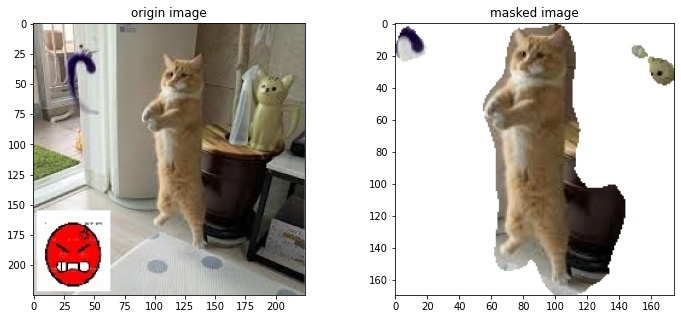

In [6]:

fig,axes = plt.subplots(1,2,figsize=(12,5),)

axes[0].imshow(image)
axes[0].set_title('origin image')

axes[1].imshow(masked_img)
axes[1].set_title('masked image')
print(f"""
    original emotion:[{origin_pred_emotion}], masked emotion:[{masked_pred_emotion}]\n
    original action:[{origin_pred_action}], masked action:[{masked_pred_action}]\n
    combination action:[{com_pred_action}]\n
    origin total pred:[{origin_total_pred}], masked total pred:[{masked_total_pred}] \n
""")
plt.show()